In [1]:
import sys
from pathlib import Path
parent_dir = str(Path().resolve().parents[3])
sys.path.append(parent_dir)

from src.utils.plot import use_svg_display
from src.utils.general import seed_all

import matplotlib.pyplot as plt

use_svg_display()
seed_all(42)

Using Seed Number 42

# Concept

```{contents}
```

## Learning Objectives

- Understand the concepts of bias, variance, and irreducible error.
- Learn how the bias and variance of a model relate to the complexity of a model.
- Visualize the tradeoff between bias and variance.
- Why does increasing number of sample decrease the Variance in the Bias-Variance tradeoff, and therefore, an effective way to curb overfitting?

## Notations

- Let $\mathcal{H}$ be the hypothesis set
- Let $\mathcal{D}$ be the underlying distribution generating the data points. Also can be represented as $\mathbb{P}(\mathcal{X}, \mathcal{Y} ; \boldsymbol{\theta})$
- Let $\mathcal{S} \sim \mathcal{D}^n$ be a training set of size $n$ sampled from the distribution $\mathcal{D}$.
- Let $h_S: \mathcal{X} \to \mathcal{Y}$ be a hypothesis learned from the training set $\mathcal{S}$.
- $\mathbb{E}_{\text{out}}(h_S)$ is same as the out-of-sample error or
    the True Risk $\mathcal{R}_{\mathcal{D}}(h_S)$.
- $\underset{{\left(\mathbf{x}, \mathbf{y}\right) \sim \mathcal{D}}}{\mathbb{E}}$ is the expectation over the distribution $\mathcal{D}$.
    - The notation $\underset{{\left(\mathbf{x}, \mathbf{y}\right) \sim \mathcal{D}}}{\mathbb{E}}$ denotes that the expectation is taken over the joint distribution $\mathcal{D}$ of the input-output pairs $(\mathbf{x}, \mathbf{y})$. In other words, it represents the average value of a function over all possible input-output pairs drawn from the distribution $\mathcal{D}$.

        To understand it better, consider a (loss) function $\ell(\mathbf{x}, \mathbf{y})$. The expectation of this function with respect to the distribution $\mathcal{D}$ can be calculated as follows:

        $$
        \underset{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}{\mathbb{E}}[\ell(\mathbf{x}, \mathbf{y})]=\int_{\mathcal{X}} \int_{\mathcal{Y}} \ell(\mathbf{x}, \mathbf{y}) \cdot \mathbb{P}(\mathcal{X}, \mathcal{Y} ; \boldsymbol{\theta}) d \mathcal{Y} d \mathcal{X}
        $$

        In this equation, $\mathbb{P}(\mathcal{X}, \mathcal{Y} ; \boldsymbol{\theta})$ represents the probability density function of the joint distribution $\mathcal{D}$, and the integral is taken over the entire input space $\mathcal{X}$ and output space $\mathcal{Y}$. This operation computes the average value of the function $\ell(\mathbf{x}, \mathbf{y})$ over all possible input-output pairs, weighted by their likelihood under the distribution $\mathcal{D}$.

        In the context of learning curves and risk minimization, the expectation over the distribution $\mathcal{D}$ is used to compute the average performance of a hypothesis on new, unseen input-output pairs drawn from the same distribution as the training data. This helps in understanding the generalization ability of the hypothesis and in choosing the best hypothesis from the hypothesis set $\mathcal{H}$, which is expected to perform well on new data points.
- $\underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}$ is the expectation over the distribution $\mathcal{D}$, and the training set $\mathcal{S}$ is sampled from the distribution $\mathcal{D}$.
    - The notation $\underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}$ represents the expectation taken over multiple training sets $\mathcal{S}$ of size $n$ sampled from the underlying data-generating distribution $\mathcal{D}$. In other words, it is an average over various realizations of the training set $\mathcal{S}$.

        In machine learning, we aim to learn a hypothesis $h_S: \mathcal{X} \to \mathcal{Y}$ from a training set $\mathcal{S}$ that generalizes well to unseen data points. However, we only have access to a single training set, which is a finite sample from the true data-generating distribution $\mathcal{D}$. Ideally, we want our learning algorithm to perform well on average over many different training sets of size $n$ sampled from $\mathcal{D}$, not just the one we happen to have.

        When we consider the expectation $\underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}$, we are accounting for this variability in the possible training sets that could have been observed. By taking the expectation over different realizations of $\mathcal{S}$, we can study the expected behavior of our learning algorithm and the hypotheses it produces.

        For example, we might be interested in the expected out-of-sample error (true risk) of a hypothesis learned from a random training set $\mathcal{S}$ of size $n$. In this case, we would calculate the expectation as:

        $$
        \underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}\left[\mathcal{R}_{\mathcal{D}}\left(h_S\right)\right] := \underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}\left[\underset{{\left(\mathbf{x}, \mathbf{y}\right) \sim \mathcal{D}}}{\mathbb{E}}\left[\ell\left(\mathbf{y}, h_S\left(\mathbf{x}\right)\right)\right]\right]
        $$

        This quantity represents the average out-of-sample error of the learned hypothesis $h_S$ across multiple possible training sets $\mathcal{S}$, each sampled from the true data-generating distribution $\mathcal{D}$. By evaluating this expectation, we can better understand the generalization properties of our learning algorithm.

## Bias-Variance Analysis

### An Introduction

**The following content is adapted from [ECE 595, Chapter 4. Learning Theory](https://engineering.purdue.edu/ChanGroup/ECE595/files/chapter4.pdf).**

The bias-variance analysis is an alternative way of analyzing the out-sample error. Instead of defining the out-sample error as the probability $\mathcal{R}_{\mathcal{D}}(h_S)=\mathbb{P}[h_S(\mathbf{x}) \neq f(\mathbf{x})]$, bias-variance analysis defines the out-sample error using the squared error:

$$
\mathbb{E}_{\text{out}}\left[h_S\right] := \mathcal{R}_{\mathcal{D}}\left(h_S\right)=\underset{{\left(\mathbf{x}, \mathbf{y}\right) \sim \mathcal{D}}}{\mathbb{E}}\left[\left(h_S(\mathbf{x})-f(\mathbf{x})\right)^{2}\right]
$$ (eq-bias-variance-tradeoff-1)

where $h_S$ is a hypothesis that is learned from the training set $\mathcal{S}$.

One thing to note is that we make the dependency of $h$ on the training dataset $\mathcal{S}$ explicit. Why? Because the sample set $\mathcal{S}$ can also be considered as a random variable, a different realization of which will result in a different hypothesis $h_S$,
and subsequently a different out-of-sample error $\mathcal{R}_{\mathcal{D}}(h_S)$.
Consequently, the out-of-sample error $\mathcal{R}_{\mathcal{D}}(h_S)$ is also a random variable, and we can compute its expectation on $\mathbb{E}_{\text{out}}$.

The expectation of the squared error $\mathbb{E}_{\text{out}}$ can be defined as:

$$
\underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}\left[\mathbb{E}_{\text{out}}\left[h_S\right]\right]=\underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}\left[\underset{{\left(\mathbf{x}, \mathbf{y}\right) \sim \mathcal{D}}}{\mathbb{E}}\left[\left(h_S(\mathbf{x})-f(\mathbf{x})\right)^{2}\right]\right]
$$

where $\mathbb{E}_{\text{out}}\left[h_S\right]$ is in itself a random variable, and we can compute its expectation over different realizations of $\mathcal{S}$.

**Here, we use $\mathcal{S} \sim \mathcal{D}^n$ to emphasize that the expectation is taken over all possible training sets of size $n$ sampled from the distribution $\mathcal{D}$, and $\left(\mathbf{x}, \mathbf{y}\right) \sim \mathcal{D}$ to emphasize that the expectation is taken over data points sampled from the distribution $\mathcal{D}$.**

### Expected Out-of-Sample Error and the Average Hypothesis

#### Notation Clarification

Do not be confused with the notation when we take the expectation of
points $(\mathbf{x}, \mathbf{y})$ sampled from the underlying distribution $\mathcal{D}$,
here in practice, we are often sampling from the test set, $\mathcal{D} \setminus \mathcal{S}$,
where $\mathcal{S}$ is the training set.

See definition 2.1 (Generalization Error), page 10 of {cite}`mohri_ameet_2018` for more clarification.
In theory we say the generalization error is the expectation over the distribution $\mathcal{D}$,
so this can include the training set $\mathcal{S}$.

#### The Average Hypothesis

The average hypothesis is a key concept when discussing the bias-variance trade-off and understanding a learning algorithm's generalization performance. It represents the expected hypothesis obtained by averaging the hypotheses learned from different training sets. In other words, it is the average of the final hypotheses produced by training the algorithm on multiple training sets sampled from the same data distribution.

Mathematically, the average hypothesis, denoted as $\overline{h_S}(\mathbf{x})$, is defined as:

$$
\overline{h_S}(\mathbf{x})=\underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}\left[h_S(\mathbf{x})\right]
$$

Here, $\mathcal{S}$ represents different training sets sampled from the same data distribution, and $h_S(\mathbf{x})$ is the hypothesis learned from a specific training set $\mathcal{S}$.

Furthermore, $\mathbf{x}$ is a point in the feature space $\mathcal{X}$, and the expectation $\underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}$ is taken over all possible training sets $\mathcal{S}$ of size $N$ sampled from the distribution $\mathcal{D}$. This means that for each point $\mathbf{x}$ in the feature space, the average hypothesis $\bar{h}(\mathbf{x})$ is the average value of the learned hypotheses $h_S(\mathbf{x})$ over all possible training sets.

#### Expected Out-of-Sample Error

```{prf:remark} Dependency of the training set $\mathcal{S}$
:label: prf:remark:dependency-of-the-training-set

We make the dependency on the training dataset $\mathcal{S}$ explicit because the sample set $\mathcal{S}$ can be considered as a random variable. If we use a different training set $\mathcal{S}$, we will get a different $\mathcal{R}_{\mathcal{D}}\left(h_S\right)$. To account for all the possible $\mathcal{S}$'s, we can compute the expectation and define the expected out-sample error:

$$
\begin{aligned}
\underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}\left[\mathbb{E}_{\text{out}}\left[h_S\right]\right] & =\underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}\left[\underset{{\left(\mathbf{x}, \mathbf{y}\right) \sim \mathcal{D}}}{\mathbb{E}}\left[\left(h_S(\mathbf{x})-f(\mathbf{x})\right)^{2}\right]\right] \\
& =\underset{{\left(\mathbf{x}, \mathbf{y}\right) \sim \mathcal{D}}}{\mathbb{E}}\left[\underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}\left[\left(h_S(\mathbf{x})-f(\mathbf{x})\right)^{2}\right]\right] \\
& =\underset{{\left(\mathbf{x}, \mathbf{y}\right) \sim \mathcal{D}}}{\mathbb{E}}\left[\underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}\left[h_S(\mathbf{x})^{2}\right]-2 \underbrace{\underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}\left[h_S(\mathbf{x})\right]}_{\overline{h_S}(\mathbf{x})} f(\mathbf{x})+f(\mathbf{x})^{2}\right]
\end{aligned}
$$ (eq-bias-variance-tradeoff-3)

Here, we define $\overline{h_S}(\mathbf{x})=\underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}\left[h_S(\mathbf{x})\right]$, which can be considered as the asymptotic limit of the estimate $\overline{h_S}(\mathbf{x}) \approx \frac{1}{K} \sum_{k=1}^{K} h_{k}(\mathbf{x})$ as $K \rightarrow \infty$. The hypotheses $h_{1}, \ldots, h_{K}$ are the final hypothesis returned by using the training sets $\mathcal{S}_{1}, \ldots, \mathcal{S}_{K}$. For any fixed $\mathbf{x}$, $h_{k}(\mathbf{x})$ is a random variable over the training set $\mathcal{S}_{k}$. However, one should be careful that even if $h_{1}, \ldots, h_{K}$ are inside the hypothesis set, the mean $\overline{h_S}$ is not necessarily inside too.
```

#### Incorporating the Irreducible Error

Note if we further assume a regression setup of the form:

$$
y = f(\mathbf{x}) + \epsilon
$$

where $\epsilon$ is a random variable representing the noise term, the irreducible error,
usually follows a mean zero and variance 1 gaussian distribution, i.e., $\mathbb{E}[\epsilon] = 0$, and a variance of $\sigma^2$, i.e., $\text{Var}[\epsilon] = \sigma^2$, and the noise term is independent of $\mathbf{x}$, then the expected out-of-sample error can be written as:

$$
\begin{aligned}
\underset{\mathcal{S} \sim D^n}{\mathbb{E}}\left[\mathbb{E}_{\text {out }}\left[h_S\right]\right] & = \underset{\mathcal{S} \sim D^n}{\mathbb{E}}\left[\underset{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}{\mathbb{E}}\left[\left(h_S(\mathbf{x})-y\right)^2\right]\right] \\
&= \underset{\mathcal{S} \sim D^n}{\mathbb{E}}\left[\underset{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}{\mathbb{E}}\left[\left(h_S(\mathbf{x})-f(\mathbf{x}) - \epsilon\right)^2\right]\right] \\
\end{aligned}
$$

### Decomposing the Expected Out-of-Sample Error

First, I'll rewrite the given expression for better readability:

$$
\mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{\text {out }}\left[h_S\right]\right]=\mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[\left(h_S(\mathbf{x})-y\right)^2\right]\right]
$$

To derive the bias-variance decomposition, we'll expand the square term and manipulate the expression as follows:

1. Expand the square term:

$$
\left(h_S(\mathbf{x})-y\right)^2=h_S(\mathbf{x})^2-2 h_S(\mathbf{x}) y+y^2
$$

2. Substitute the expanded term back into the expression:

$$
\mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[h_S(\mathbf{x})^2-2 h_S(\mathbf{x}) y+y^2\right]\right]
$$

3. Distribute the inner expectation $\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}$ over the sum:

$$
\mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[h_S(\mathbf{x})^2\right]-2 \mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[h_S(\mathbf{x}) y\right]+\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[y^2\right]\right]
$$

4. Apply the double expectation rule, which states that the expectation of an expectation is equal to the expectation itself, and reorder the terms:

$$
\mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[h_S(\mathbf{x})^2\right]\right]-2 \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[h_S(\mathbf{x}) y\right]\right]+\mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[y^2\right]\right]
$$

5. Since $y = f(\mathbf{x}) + \epsilon$, where $\epsilon$ is the irreducible error, we can substitute this relationship into the expression, replacing each $y$ with $f(\mathbf{x}) + \epsilon$:

    $$
    \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[h_S(\mathbf{x})^2\right]\right]-2 \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[h_S(\mathbf{x})(f(\mathbf{x})+\epsilon)\right]\right]+\mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[(f(\mathbf{x})+\epsilon)^2\right]\right]
    $$

6. Distribute the middle term and apply the expectation rule:

    $$
    \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[h_S(\mathbf{x})^2\right]\right]-2 \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[h_S(\mathbf{x}) f(\mathbf{x})\right]\right]-2 \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[h_S(\mathbf{x}) \epsilon\right]\right]+\mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[(f(\mathbf{x})+\epsilon)^2\right]\right]
    $$

7. Since $\mathbb{E}[\epsilon] = 0$, the third term becomes zero, and we are left with:

    $$
    \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[h_S(\mathbf{x})^2\right]\right]-2 \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[h_S(\mathbf{x}) f(\mathbf{x})\right]\right]+\mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[(f(\mathbf{x})+\epsilon)^2\right]\right]
    $$

8. Next, we'll rewrite the first and second terms using the expected hypothesis $\bar{h}(\mathbf{x})$:

    $$
    \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{\mathbf{x} \sim \mathcal{D}}\left[\left(h_S(\mathbf{x})-\bar{h}(\mathbf{x})+\bar{h}(\mathbf{x})\right)^2\right]\right]-2 \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{\mathbf{x} \sim \mathcal{D}}\left[\left(h_S(\mathbf{x})-\bar{h}(\mathbf{x})+\bar{h}(\mathbf{x})\right) f(\mathbf{x})\right]\right]+\mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[(f(\mathbf{x})+\epsilon)^2\right]\right]
    $$

9. Now, we'll expand the squares and cross-terms in the first term and the cross-terms in the second term:

    $$
    \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{\mathbf{x} \sim \mathcal{D}}\left[\left(h_S(\mathbf{x})-\bar{h}(\mathbf{x})\right)^2+2\left(h_S(\mathbf{x})-\bar{h}(\mathbf{x})\right) \bar{h}(\mathbf{x})+\bar{h}(\mathbf{x})^2\right]\right]-2 \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{\mathbf{x} \sim \mathcal{D}}\left[\left(h_S(\mathbf{x})-\bar{h}(\mathbf{x})\right) f(\mathbf{x})+\bar{h}(\mathbf{x}) f(\mathbf{x})\right]\right]+\mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[(f(\mathbf{x})+\epsilon)^2\right]\right]
    $$

10. The cross-terms will cancel out:

    $$
    \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{\mathbf{x} \sim \mathcal{D}}\left[\left(h_S(\mathbf{x})-\bar{h}(\mathbf{x})\right)^2+\bar{h}(\mathbf{x})^2\right]\right]-2 \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{\mathbf{x} \sim \mathcal{D}}[\bar{h}(\mathbf{x}) f(\mathbf{x})]\right]+\mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}\left[(f(\mathbf{x})+\epsilon)^2\right]\right]
    $$

11. Next, we'll expand the last term:

    $$
    \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{\mathbf{x} \sim \mathcal{D}}\left[\left(h_S(\mathbf{x})-\bar{h}(\mathbf{x})\right)^2+\bar{h}(\mathbf{x})^2\right]\right]-2 \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{\mathbf{x} \sim \mathcal{D}}[\bar{h}(\mathbf{x}) f(\mathbf{x})]\right]+\mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{\mathbf{x} \sim \mathcal{D}}\left[f(\mathbf{x})^2+2 f(\mathbf{x}) \epsilon+\epsilon^2\right]\right]
    $$

12. Since $\mathbb{E}[\epsilon] = 0$, the cross-term in the last term vanishes, and we are left with:

    $$
    \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{\mathbf{x} \sim \mathcal{D}}\left[\left(h_S(\mathbf{x})-\bar{h}(\mathbf{x})\right)^2+\bar{h}(\mathbf{x})^2\right]\right]-2 \mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{\mathbf{x} \sim \mathcal{D}}[\bar{h}(\mathbf{x}) f(\mathbf{x})]\right]+\mathbb{E}_{\mathcal{S} \sim D^n}\left[\mathbb{E}_{\mathbf{x} \sim \mathcal{D}}\left[f(\mathbf{x})^2+\epsilon^2\right]\right]
    $$

13. We can now regroup the terms to isolate the variance and bias components

    $$
    \underset{\mathcal{S} \sim D^n}{\mathbb{E}}\left[\mathbb{E}_{\text {out }}\left[h_S\right]\right]=\underset{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}}{\mathbb{E}}\left[\underbrace{\underset{\mathcal{S} \sim D^n}{\mathbb{E}}\left[\left(h_S(\mathbf{x})-\overline{h_S}(\mathbf{x})\right)^2\right]}_{\text {Variance }}+\underbrace{\left(\overline{h_S}(\mathbf{x})-f(\mathbf{x})\right)^2}_{\text {Bias }^2}+\underbrace{\mathbb{E}\left[\epsilon^2\right]}_{\text {Irreducible Error }}\right]
    $$

    where $\epsilon^2 := (\mathbf{y}-f(\mathbf{x}))^2$ is the irreducible error.

    Now, we have successfully decomposed the expected out-of-sample error into bias, variance, and irreducible error components:

    $$
    \text { Expected Error }=\text { Bias }^2+\text { Variance }+ \text { Irreducible Error }
    $$



Based on this decomposition, we can define two terms:

$$
\begin{aligned}
\operatorname{bias}(\mathbf{x}) & \stackrel{\text { def }}{=}(\overline{h_S}(\mathbf{x})-f(\mathbf{x}))^{2}, \\
\operatorname{var}(\mathbf{x}) & \stackrel{\text { def }}{=} \mathbb{E}_{\mathcal{S} \sim D^n}\left[\left(h_S(\mathbf{x})-\overline{h_S}(\mathbf{x})\right)^2\right].
\end{aligned}
$$

The first term is called the bias, as it measures the deviation between the average function $\overline{h_S}(\mathbf{x})$ and the target function $f(\mathbf{x})$. Thus, regardless of how we pick the particular training set, there is an intrinsic gap between the what we would expect $(\overline{h_S}(\mathbf{x}))$ and the ideal target $f(\mathbf{x})$. The second term is called the variance. It measures the variance of the random variable $h_S(\mathbf{x})$ with respect to its mean $\overline{h_S}(\mathbf{x})$. Using the bias and variance decomposition, we can show that

$$
\begin{aligned}
\underset{\mathcal{S} \sim D^n}{\mathbb{E}}\left[\mathbb{E}_{\text {out }}\left[h_S\right]\right] & =\mathbb{E}_{\left(\mathbf{x}, \mathbf{y}\right) \sim \mathcal{D}}\left[\operatorname{bias}(\mathbf{x})+\operatorname{var}(\mathbf{x})+\mathbb{E}\left[\epsilon^2\right]\right] \\
& =\text { bias }+\text { var } +\text { irreducible error } \\
\end{aligned}
$$

where bias $=\mathbb{E}_{\left(\mathbf{x}, \mathbf{y}\right) \sim \mathcal{D}}[\operatorname{bias}(\mathbf{x})]$ is the average bias over the distribution $\mathcal{D}$, and $\operatorname{var}=\mathbb{E}_{\left(\mathbf{x}, \mathbf{y}\right) \sim \mathcal{D}}[\operatorname{var}(\mathbf{x})]$ is the average variance over $\mathcal{D}$.

```{prf:remark} Expected Bias and Variance
:label: prf:remark:expected-bias-and-variance

To clarify further, the earlier $\text{bias}(\mathbf{x})$ and $\text{var}(\mathbf{x})$ are
just over a single point $\mathbf{x}$, so we should take the expectation over the distribution $\mathcal{D}$ to get the average bias and variance over the entire distribution $\mathcal{D}$.

In the context of this formula, bias is calculated for each point $\mathbf{x}$ in the distribution, then averaged over the entire distribution to give a single measure of bias for the model. This reflects how the model's predictions, on average, deviate from the true values across the whole input space, as defined by distribution $\mathcal{D}$.

This average bias provides an aggregate measure of how much the model's predictions consistently miss the true target value. It reflects the extent to which the model’s predictions are systematically too high or too low. If the average bias is high, this suggests that the model’s assumptions are not well-suited to the true underlying function.

Similarly, the variance term is the average variance over the distribution $\mathcal{D}$. This measures how much the model's predictions vary for different training sets. If the variance is high, this suggests that the model is highly sensitive to the specific training data it sees and is likely overfitting.

So, indeed, both bias and variance are calculated as averages over the distribution $\mathcal{D}$ in the bias-variance decomposition of expected generalization error.
```

#### Bias-Variance Tradeoff and Model Complexity

What can we say about the bias-variance decomposition when analyzing the model complexity? We can consider two extreme cases. In the first case, we have a very simple model and so $\mathcal{H}$ is small. Since there are not many choices of the hypothesis, the deviation between the target $f$ and the average of these hypotheses $\overline{h_S}$ is large. Thus, the bias is large. On the other hand, the variance is limited because we only have very few hypotheses in $\mathcal{H}$.

The second case is when we have a complex model. By selecting different training sets D's, we will be able to select hypothesis functions $g_{1}, \ldots, g_{K}$ that agree with $f$. In this case, the deviation between the target $f$ and the average of these hypotheses $\overline{h_S}$ is very small. The bias is thus bias $\approx 0$. The variance, however, is large because there are many training sets under consideration.

### Average Hypothesis Minimizes the Expected Out-of-Sample Error

To show that the average hypothesis minimizes the expected error, we will consider the expected out-of-sample error as defined in equation (eq-bias-variance-tradeoff-1):

$$
\mathbb{E}_{\text{out}}\left[h_S\right] := \mathcal{R}_{\mathcal{D}}\left(h_S\right)=\underset{{\left(\mathbf{x}, \mathbf{y}\right) \sim \mathcal{D}}}{\mathbb{E}}\left[\left(h_S(\mathbf{x})-f(\mathbf{x})\right)^{2}\right]
$$

Now let's consider the average hypothesis, as defined by:

$$
\overline{h_S}(\mathbf{x})=\underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}\left[h_S(\mathbf{x})\right]
$$

We want to show that the expected error of the average hypothesis is less than or equal to the expected error of individual hypotheses. Let's compute the expected error of the average hypothesis:

$$
\mathbb{E}_{\text{out}}\left[\overline{h_S}\right] := \mathcal{R}_{\mathcal{D}}\left(\overline{h_S}\right)=\underset{{\left(\mathbf{x}, \mathbf{y}\right) \sim \mathcal{D}}}{\mathbb{E}}\left[\left(\overline{h_S}(\mathbf{x})-f(\mathbf{x})\right)^{2}\right]
$$

Now, rewrite the expected error of the average hypothesis in terms of the expected error of individual hypotheses:

$$
\begin{aligned}
\mathbb{E}_{\text{out}}\left[\overline{h_S}\right] &= \underset{{\left(\mathbf{x}, \mathbf{y}\right) \sim \mathcal{D}}}{\mathbb{E}}\left[\left(\underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}\left[h_S(\mathbf{x})\right]-f(\mathbf{x})\right)^{2}\right] \\
&= \underset{{\left(\mathbf{x}, \mathbf{y}\right) \sim \mathcal{D}}}{\mathbb{E}}\left[\left(\underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}\left[h_S(\mathbf{x}) - f(\mathbf{x})\right]\right)^2\right]
\end{aligned}
$$

Apply Jensen's inequality, which states that for a convex function $\phi$, $\phi(\mathbb{E}[X]) \le \mathbb{E}[\phi(X)]$. Since the square function is convex, we can apply Jensen's inequality to the previous expression:

$$
\mathbb{E}_{\text{out}}\left[\overline{h_S}\right] \le \underset{{\left(\mathbf{x}, \mathbf{y}\right) \sim \mathcal{D}}}{\mathbb{E}}\left[\underset{\mathcal{S} \sim \mathcal{D}^n}{\mathbb{E}}\left[\left(h_S(\mathbf{x}) - f(\mathbf{x})\right)^2\right]\right]
$$

Now, we can see that the right-hand side is the expected out-of-sample error for individual hypotheses as defined in equation (eq-bias-variance-tradeoff-1):

$$
\mathbb{E}_{\text{out}}\left[\overline{h_S}\right] \le \mathbb{E}_{\text{out}}\left[h_S\right]
$$

This inequality shows that the expected error of the average hypothesis is less than or equal to the expected error of individual hypotheses. Therefore, the average hypothesis minimizes the expected error.

## Demonstration of Bias-Variance Tradeoff

Consider a target function $f(x)=\sin (\pi x)$:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional

# Target Ground Truth Function
# f: [-1, 1] \mapsto \mathbb{R}
def f(x: float) -> float:
    """Compute the target function sin(pi * x)."""
    return np.sin(np.pi * x)

We can plot the target function:

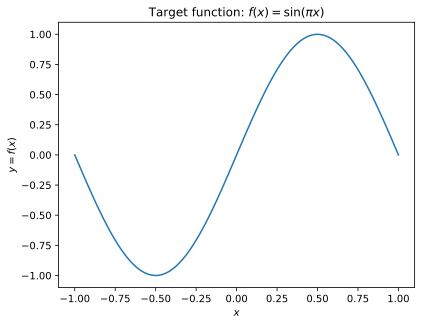

In [3]:
# Just a plot only
x_range = np.linspace(-1, 1, 100)
y_range = f(x_range)

plt.plot(x_range, y_range)
plt.xlabel('$x$')
plt.ylabel('$y=f(x)$')
plt.title('Target function: $f(x)=\sin(\pi x)$')
plt.show()

Note that since the ground truth function is defined, we know the underlying
distribution $\mathcal{D}$ of the data. We can sample from this distribution
to generate a training set $\mathcal{S}$.

Let's define the function to generate a training set $\mathcal{S}$:

In [4]:
def generate_X(num_samples: int) -> np.ndarray:
    """Our $\mathcal{S}$ is the set of points generated in a uniform distribution from 0 to 1
    It thus follows that any sample X will be generated from this distribution
    """
    # Prof says generate x uniformly from say 0 to 1
    # This is sampling from the whole domain (population)
    X = np.random.uniform(low=-1.0, high=1.0, size=num_samples)
    return X

We consider a dataset $\mathcal{S}$ of size $N=2$. We sample uniformly in the interval $[-1,1]$ to generate a data set containing two data points $\left(x_{1}, y_{1}\right)$ and $\left(x_{2}, y_{2}\right)$. We want to use these two data points to determine which of the following two models (hypothesis) are better:

$$
\mathcal{H}_0 = \left\{h(\mathbf{x}) = b \mid b \in \mathbb{R}\right\} \quad \text { and } \quad \mathcal{H}_1 = \left\{h(\mathbf{x}) = ax+b \mid a, b \in \mathbb{R}\right\}
$$

We can define them in python below:

In [5]:
def H0(x: np.ndarray, b: float) -> np.ndarray:
    """Compute the constant value for Model H0 given the input data points."""
    return b * np.ones_like(x)

def H1(x: np.ndarray, a: float, b: float) -> np.ndarray:
    """Compute the linear value for Model H1 given the input data points."""
    return a * x + b

The plot below illustrates the two models. The model $\mathcal{H}_{0}$ is a horizontal line, while the model $\mathcal{H}_{1}$ is a straight line that can be arbitrarily tilted.

X: [-0.25091976  0.90142861]


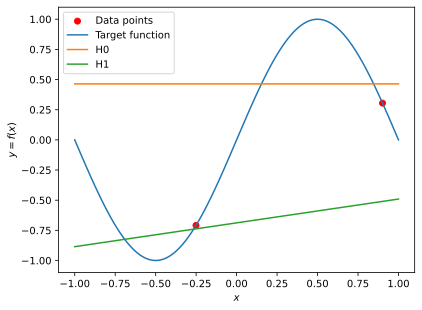

In [6]:
X = generate_X(2)
print(f'X: {X}')

y = f(X)  # ground truth

b = np.random.uniform(-1, 1)
h0 = H0(x_range, b)

a, b = np.random.uniform(-1, 1, 2)
h1 = H1(x_range, a, b)

plt.scatter(X, y, c='red', label='Data points')
plt.plot(x_range, y_range, label='Target function')
plt.plot(x_range, h0, label='H0')
plt.plot(x_range, h1, label='H1')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y=f(x)$')
plt.show()

Now we see that the lines are randomly chosen from $\mathcal{H}_{0}$ and $\mathcal{H}_{1}$
respectively. However, the two lines are not the best choices for the two models.
In other words, they are not "best fit" lines. In regression, we typically use the
least squares method to find the best fit line. We call the method to find the best
fit line, the **learning algorithm** $\mathcal{A}$.

More concretely, given two data points, $\mathcal{H}_{0}$ seeks a horizontal line $h(x)=b$ that matches the two data points. This line must be the one that passes through the mid-point of the two data points. The model $\mathcal{H}_{1}$ is allowed to find an arbitrary straight line that matches the two data points. Since there are only two data points, the best straight must be the one that passes through both of them. More specifically, the line returned by $\mathcal{H}_{0}$ is

$$
h(x)=\frac{y_{1}+y_{2}}{2}
$$

and the line returned by $\mathcal{H}_{1}$ is

$$
h(x)=\left(\frac{y_{2}-y_{1}}{x_{2}-x_{1}}\right) x+\left(y_{1} x_{2}-y_{2} x_{1}\right) .
$$

As we change $\left(x_{1}, y_{1}\right)$ and $\left(x_{2}, y_{2}\right)$, we will obtain different straight lines.

In other words, we say that the learning algorithm for $\mathcal{H}_{0}$ is one $\mathcal{A}$ that chooses $b = \dfrac{y_1 + y_2}{2}$, or more generally if we have $N$ sample points, $b = \dfrac{y_1 + y_2 + ... + y_N}{N}$

Then the learning algorithm for $\mathcal{H}_{1}$ is we choose $a = \dfrac{y_2-y_1}{x_2-x_1}$ and $b = y_1 - a \cdot x_1$.

Let's define these two learning algorithms in python, where they
return the fitted parameters.

In [7]:
def A0(x1: float, y1: float, x2: float, y2: float, x: Optional[np.ndarray] = None) -> float:
    """Compute the constant value for Model H0 given the input data points."""
    b = (y1 + y2) / 2
    return b

def A1(x1: float, y1: float, x2: float, y2: float, x: Optional[np.ndarray] = None) -> float:
    """Compute the value of Model H1 given the input data points and x."""
    a = (y2 - y1) / (x2 - x1)
    b = (y1 * x2 - y2 * x1) / (x2 - x1)
    return a, b

Then, we replot again, this time we use the parameters returned by the learning algorithms.

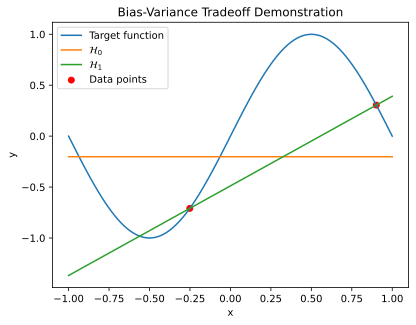

In [8]:
x1, x2 = X
y1, y2 = y

plt.plot(x_range, y_range, label='Target function')

b = A0(x1, y1, x2, y2)
H0_y = H0(x_range, b)
plt.plot(x_range, H0_y, label='$\mathcal{H}_0$')

a, b = A1(x1, y1, x2, y2, x_range)
H1_y = H1(x_range, a, b)
plt.plot(x_range, H1_y, label='$\mathcal{H}_1$')

plt.scatter([x1, x2], [y1, y2], c='red', label='Data points')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Bias-Variance Tradeoff Demonstration')
plt.show()

If we keep drawing two random samples from the sine function, we will eventually get a set of straight lines for both cases. What this means here is the collection of all possible straight lines for $\mathcal{H}_{0}$ is the set of all horizontal lines, and the collection of all possible straight lines for $\mathcal{H}_{1}$ is the set of all straight lines.

However, since $\mathcal{H}_{0}$ restricts ourselves to horizontal lines, the set of straight lines are all horizontal. In contrast, the set of straight lines for $\mathcal{H}_{1}$ contains lines of different slopes and $y$-intercepts.

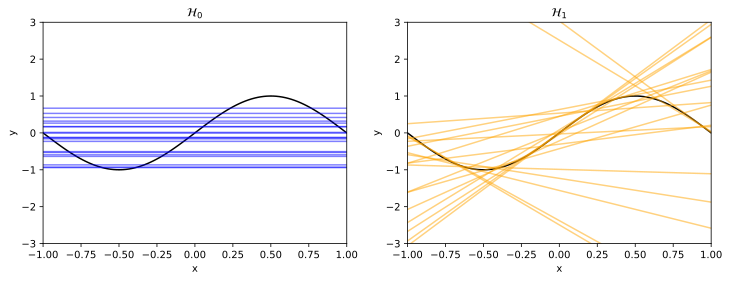

In [9]:
num_trials = 20

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(x_range, y_range, c='black', label='Target function')
axes[1].plot(x_range, y_range, c='black', label='Target function')

# Set the same x and y limits for both subplots
x_min, x_max = -1, 1
y_min, y_max = -3, 3

axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(y_min, y_max)

for i in range(num_trials):
    X = generate_X(2)
    y = f(X)

    x1, x2 = X
    y1, y2 = y

    b = A0(x1, y1, x2, y2)
    H0_y = H0(x_range, b)
    axes[0].plot(x_range, H0_y, c='blue', alpha=0.5)

    a, b = A1(x1, y1, x2, y2, x_range)
    H1_y = H1(x_range, a, b)
    axes[1].plot(x_range, H1_y, c='orange', alpha=0.5)

axes[0].set_title('$\mathcal{H}_0$')
axes[1].set_title('$\mathcal{H}_1$')
axes[0].set_xlabel('x')
axes[1].set_xlabel('x')
axes[0].set_ylabel('y')
axes[1].set_ylabel('y')

plt.show()

Note very carefully here that the plot above is repeating the experiment 20 times, that means
each time we draw a different set $\mathcal{S} = \left\{\left(x_{1}, y_{1}\right), \left(x_{2}, y_{2}\right)\right\}$ from the target function $f$ (underlying distribution). In other words, we are fitting the model $\mathcal{H}_{0}$ and $\mathcal{H}_{1}$ to 20 different sets of data points.

As we increase the number of experiments, the set of straight lines will form a distribution of the model. Since now we have a distribution, we can determine is mean, which is a function, as $\overline{h_S}$. Similarly, we can determine the variance of the function $\operatorname{var}(x)$. For example, in the below plot we draw the possible lines that are within one standard deviation from the mean function, i.e., $\overline{h_S} \pm \sqrt{\operatorname{var}(x)}$.

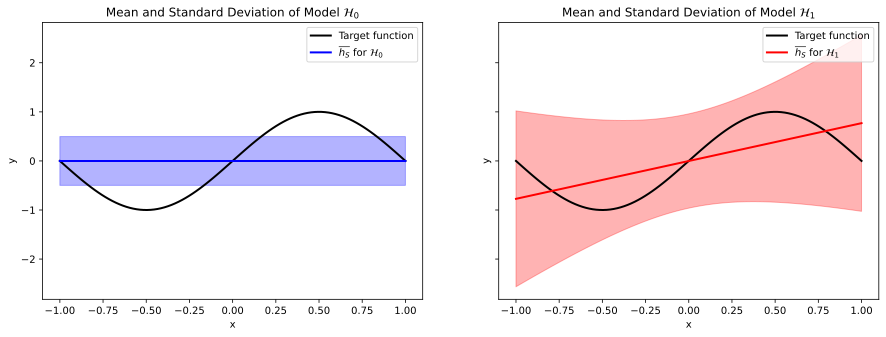

In [10]:
num_experiments = 3000
num_samples = 2

h0_list = []
h1_list = []

for _ in range(num_experiments):
    X = generate_X(num_samples)
    y = f(X)

    x1, x2 = X
    y1, y2 = y

    b = A0(x1, y1, x2, y2)
    H0_y = H0(x_range, b)
    h0_list.append(H0_y)

    a, b = A1(x1, y1, x2, y2, x_range)
    H1_y = H1(x_range, a, b)
    h1_list.append(H1_y)

h0_list = np.array(h0_list)
h1_list = np.array(h1_list)

h0_mean = np.mean(h0_list)
h0_std = np.std(h0_list)

h1_mean = np.mean(h1_list, axis=0)
h1_std = np.std(h1_list, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

axes[0].plot(x_range, y_range, label='Target function', c='black', linewidth=2)
axes[0].plot(x_range, h0_mean * np.ones_like(x_range), label='$\overline{h_S}$ for $\mathcal{H}_0$', c='blue', linewidth=2)
axes[0].fill_between(x_range, (h0_mean - h0_std) * np.ones_like(x_range), (h0_mean + h0_std) * np.ones_like(x_range), color='blue', alpha=0.3)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].legend()
axes[0].set_title('Mean and Standard Deviation of Model $\mathcal{H}_0$')

axes[1].plot(x_range, y_range, label='Target function', c='black', linewidth=2)
axes[1].plot(x_range, h1_mean, label='$\overline{h_S}$ for $\mathcal{H}_1$', c='red', linewidth=2)
axes[1].fill_between(x_range, h1_mean - h1_std, h1_mean + h1_std, color='red', alpha=0.3)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].legend()
axes[1].set_title('Mean and Standard Deviation of Model $\mathcal{H}_1$')

plt.show()

So which model is better in terms of bias-variance? If we compute the bias and variance, we can show that

$$
\begin{array}{ll}
\operatorname{bias}_{\mathcal{H}_{0}}=0.5, & \operatorname{bias}_{\mathcal{H}_{1}}=0.21 \\
\operatorname{var}_{\mathcal{H}_{0}}=0.25, & \operatorname{var}_{\mathcal{H}_{1}}=1.69
\end{array}
$$

```{prf:proof}
In the given problem, we have two models, $\mathcal{H}_0$ and $\mathcal{H}_1$. The true function $f(x) = x^2$, and we're generating data points in the range of $x = [0, 1]$. Let's analyze the bias and variance of each model.

**Model $\mathcal{H}_0$** is a constant function $h(x) = b$, where $b = \frac{y_1 + y_2}{2}$.

Bias: The bias is the expected difference between the true function and the hypothesis. We can compute the bias by integrating the difference between the true function and the hypothesis, and then dividing by the range of $x$.

Let's confirm this by simulation. Note the code below is very similar to the code above.

$$
\operatorname{bias}_{\mathcal{H}_0}=\frac{1}{1-0} \int_0^1\left(x^2-b\right)^2 d x
$$

Since $b = \frac{y_1 + y_2}{2}$ and $y_i = x_i^2$, we have $b = \frac{x_1^2 + x_2^2}{2}$. Substituting this in the integral:

$$
\operatorname{bias}_{\mathcal{H}_0}=\frac{1}{1-0} \int_0^1\left(x^2-\frac{x_1^2+x_2^2}{2}\right)^2 d x
$$

Taking the expectation over $x_1$ and $x_2$, we get:

$$
\operatorname{bias}_{\mathcal{H}_0}=E_{x_1, x_2}\left[\frac{1}{1-0} \int_0^1\left(x^2-\frac{x_1^2+x_2^2}{2}\right)^2 d x\right] \approx 0.5
$$

Variance: The variance is the expected difference between the hypothesis and the average hypothesis. We can compute the variance by integrating the difference between the hypothesis and the average hypothesis, and then dividing by the range of $x$.

$$
\operatorname{var}_{\mathcal{H}_0}=\frac{1}{1-0} \int_0^1(b-E[b])^2 d x
$$

Since $b = \frac{x_1^2 + x_2^2}{2}$, we have $E[b] = E[\frac{x_1^2 + x_2^2}{2}] = \frac{1}{3}$. Substituting this in the integral:

$$
\operatorname{var}_{\mathcal{H}_0}=E_{x_1, x_2}\left[\frac{1}{1-0} \int_0^1\left(\frac{x_1^2+x_2^2}{2}-\frac{1}{3}\right)^2 d x\right] \approx 0.25
$$
```

In [11]:
from typing import Callable, List, Tuple

def bias_variance_simulation(num_simulations: int, num_samples: int, X_test: np.ndarray, Y_test: np.ndarray,
                             generate_X: Callable, f_true: Callable, A: Callable, H: Callable) -> Tuple[float, float, float]:
    """
    Simulates the bias and variance for a given model.

    Parameters
    ----------
    num_simulations: int
        Number of simulations to run.
    num_samples: int
        Number of samples to draw from the population for each simulation.
    X_test: np.ndarray
        Test input data.
    Y_test: np.ndarray
        Test output data (true labels).
    generate_X: Callable
        Function to generate the input data.
    f_true: Callable
        True function that maps input data to output data.
    A: Callable
        Learning algorithm function that returns model parameters.
    H: Callable
        Hypothesis function that predicts output data given input data and model parameters.

    Returns
    -------
    bias_squared: float
        The squared bias of the model.
    variance: float
        The variance of the model.
    expected_mse: float
        The expected mean squared error of the model.
    """

    total_mse = 0
    predictions_list = []

    for sim in range(num_simulations):
        X_sampled = generate_X(num_samples=num_samples)
        Y_sampled = f_true(X_sampled)

        x_1, x_2 = X_sampled
        y_1, y_2 = Y_sampled

        model_params = A(x_1, y_1, x_2, y_2)
        if isinstance(model_params, tuple): # means more than one parameter
            prediction = H(X_test, *model_params)
        else:
            prediction = H(X_test, model_params)

        predictions_list.append(prediction)

        mse = np.mean((Y_test - prediction)**2)
        total_mse += mse

    expected_mse = total_mse / num_simulations
    predictions_array = np.array(predictions_list)
    h_bar = np.mean(predictions_array, axis=0)
    bias_squared = np.mean((h_bar - Y_test) ** 2)
    variance = np.mean((predictions_array - h_bar) ** 2)

    return bias_squared, variance, expected_mse

In [12]:
seed_all(42)  # Reset seed!
num_simulations = 3000
num_samples = 2

# Generate a set of test points covering the entire range of x
X_test = generate_X(num_samples=10000)
Y_test = f(X_test)

bias_H0, variance_H0, expected_mse_H0 = bias_variance_simulation(num_simulations, num_samples, X_test, Y_test, generate_X, f, A0, H0)

print("Expected MSE/Generalization Error for H0", expected_mse_H0)
print("Bias Squared for H0", bias_H0)
print("Variance for H0", variance_H0)
print("Bias + Variance", bias_H0 + variance_H0)

Using Seed Number 42

Expected MSE/Generalization Error for H0 0.7518066104381365
Bias Squared for H0 0.4968378933075949
Variance for H0 0.25496871713054253
Bias + Variance 0.7518066104381375


And for the second hypothesis set $\mathcal{H}_1$:

In [13]:
seed_all(42)  # Reset seed!
num_simulations = 3000
num_samples = 2

# Generate a set of test points covering the entire range of x
X_test = generate_X(num_samples=10000)
Y_test = f(X_test)

bias_H1, variance_H1, expected_mse_H1 = bias_variance_simulation(num_simulations, num_samples, X_test, Y_test, generate_X, f, A1, H1)

print("Expected MSE/Generalization Error for H1", expected_mse_H1)
print("Bias Squared for H1", bias_H1)
print("Variance for H1", variance_H1)
print("Bias + Variance", bias_H1 + variance_H1)

Using Seed Number 42

Expected MSE/Generalization Error for H1 1.9141919732838053
Bias Squared for H1 0.21040717849966076
Variance for H1 1.7037847947841498
Bias + Variance 1.9141919732838106


### Who is the winner?

**This section is extracted from [ECE595: Learning Theory](https://engineering.purdue.edu/ChanGroup/ECE595/files/chapter4.pdf).**

Therefore, as far as generalization is concerned, a simple model using a horizontal line is actually more preferred in the bias-variance sense. This is counter-intuitive because how can a horizontal line with only one degree of freedom be better than a line with two degrees of freedom when approximating the sine function? However, the objective here is not to use a line to approximate a sine function because we are not supposed to observe the entire sine function. Remember, we are only allowed to see two data points and our goal is to
construct a line based on these two data points. The approximation error in the usual sense is captured by the bias, as $\overline{h_S}$ is the best possible line within the class. The generalization, however, should also take into account of the variance. While $\mathcal{H}_{1}$ has a lower bias, its variance is actually much larger than that of $\mathcal{H}_{0}$. The implication is that while on average $\mathcal{H}_{1}$ performs well, chances are we pick a bad line in $\mathcal{H}_{1}$ that end up causing very undesirable out-sample performance.

One thing to pay attention to is that the above analysis is based on $N=2$ data points. If we increase the number of data points, the variance of $\mathcal{H}_{1}$ will drop. As $N \rightarrow \infty$, the variance of both $\mathcal{H}_{0}$ and $\mathcal{H}_{1}$ will eventually drop to zero and so only the bias term matters. Therefore, if we have infinitely many training data, a complex model will of course provide a better generalization.

## Bias-Variance Tradeoff and the VC Dimension

The bias-variance decomposition is an alternative approach to understanding generalization bounds, differing from the VC Dimension method. Here, we highlight the distinctions between the two and discuss their implications in practice.

While both bias-variance decomposition and VC Dimension analysis deal with the generalization error of a hypothesis set $\mathcal{H}$, there is a subtle yet important difference between them. The bias-variance analysis depends on the learning algorithm $\mathcal{A}$, whereas the VC analysis is independent of $\mathcal{A}$. For a given hypothesis set $\mathcal{H}$, the VC Dimension will always return the same generalization bound, providing a uniform performance guarantee across all possible choices of dataset $\mathcal{S}$. In contrast, with the bias-variance decomposition, the same hypothesis set $\mathcal{H}$ can yield different $h_S$ depending on the choice of dataset $\mathcal{S}$. This difference is reflected in the bias and variance terms of $\mathbb{E}_{\text{out}}\left(h_S\right)$. Nevertheless, the overall bias-variance decomposition remains independent of $\mathcal{S}$, as we consider the expectation $\mathbb{E}_{\mathcal{S} \sim \mathcal{D}}\left[\mathbb{E}_{\text{out}}\left(h_S\right)\right]$. VC analysis does not have this issue.

In practice, calculating bias and variance is often infeasible because we typically lack access to the target function. If we knew the target function, there would be nothing left to learn! As a result, the bias-variance decomposition serves primarily as a conceptual tool to guide the design of learning algorithms. For instance, one might try to reduce the bias while maintaining the variance (e.g., through regularization or specifying a prior), or alternatively, decrease the variance while preserving the bias.

## Learning Curve Theory

> There are some cross over of this section with [](../../model_selection_and_evaluation/learning_curve_theory/implementation.ipynb),
> so you may want to read that section in tandem with this one.

Both bias-variance and VC analysis provide a trade-off between model complexity and sample complexity. {numref}`ece595_fig4.11`shows a typical scenario. Suppose that we have learned an final hypothesis $h_S$ using dataset $\mathcal{S}$ of size $N$. This final hypothesis will give us an in-sample error $\hat{\mathcal{R}}_{\mathcal{S}}\left(h_S\right)$ and out-sample error $\mathcal{R}_{\mathcal{D}}\left(h_S\right)$. These two errors are functions of the dataset $\mathcal{S}$. If we take the expectation over $\mathcal{S}$, we will obtain the expected error $\mathbb{E}_{\mathcal{S}}\left[\hat{\mathcal{R}}_{\mathcal{S}}\left(h_S\right)\right]$ and $\mathbb{E}_{\mathcal{S}}\left[\mathcal{R}_{\mathcal{D}}\left(h_S\right)\right]$. These expected error will give us two curves, as shown in
{numref}`ece595_fig4.12`.

If we have a simple model, the in-sample error $\mathbb{E}_{\mathcal{S}}\left[E_{\mathrm{in}}\left(h_S\right)\right]$ is a good approximate of the out-sample error $\mathbb{E}_{\mathcal{S}}\left[\mathcal{R}_{\mathcal{D}}\left(h_S\right)\right]$. This implies a small gap between the two. However, the overall expected error could still be large because our model is simple. This is reflected in the high off-set in the learning curve.

If we have a complex model. the in-sample error $\mathbb{E}_{\mathcal{S}}\left[\hat{\mathcal{R}}_{\mathcal{S}}\left(h_S\right)\right]$ would be small because we are able to fit the training data. However, the out-sample error is large $\mathbb{E}_{\mathcal{S}}\left[\mathcal{R}_{\mathcal{D}}\left(h_S\right)\right]$ because the generalization using a complex model is difficult. The two curves will eventually meet as $N$ grows, since the variance of the out-sample will drop. The convergence rate is slower than a simple model, because it take many more samples for a complex model to generalize well.

```{figure} ../assets/ece595_fig4.11.png
---
name: ece595_fig4.11
---

Learning curves of a simple and a complex model. Image Credit: ECE595.
```


The VC analysis and the bias-variance analysis provide two different view of decomposing the error. VC analysis decompose $\mathcal{R}_{\mathcal{D}}$ as the in-sample error $\hat{\mathcal{R}}_{\mathcal{S}}(h_S)$ and the generalization error $\epsilon$. This $\epsilon$ is the gap between $\hat{\mathcal{R}}_{\mathcal{S}}$ and $\mathcal{R}_{\mathcal{D}}$. The bias-variance analysis decompose $\mathcal{R}_{\mathcal{D}}$ as bias and variance. The bias is the residue caused by the average hypothesis $\overline{h_S}$. The bias is a fixed quantity and does not change over $N$. The gap between $\mathcal{R}_{\mathcal{D}}$ and the bias is the variance. The variance drops as $N$ increases.
![](https://cdn.mathpix.com/cropped/2023_02_26_b748253e20a8cfd225a0g-27.jpg?height=472&width=1302&top_left_y=1810&top_left_x=390)

```{figure} ../assets/ece595_fig4.12.png
---
name: ece595_fig4.12
---

[Left] VC analysis. [Right] Bias-variance analysis. Image Credit: ECE595.
```

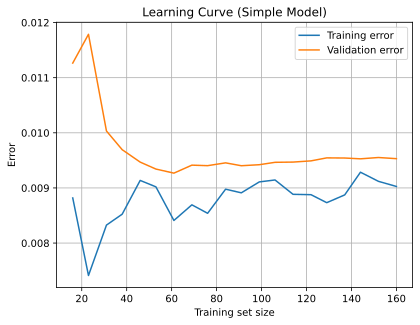

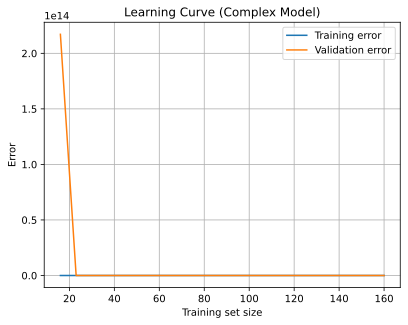

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from typing import Tuple


def create_data(
    n_samples: int, noise_std: float = 0.1
) -> Tuple[np.ndarray, np.ndarray]:
    np.random.seed(0)
    X = np.random.uniform(-5, 5, n_samples)
    y = X ** 3 - 5 * X ** 2 + 3 * X + 20 + np.random.normal(0, noise_std, n_samples)
    X = X[:, np.newaxis]
    return X, y


def plot_learning_curve(
    X: np.ndarray,
    y: np.ndarray,
    model: Pipeline,
    title: str,
    score: str = "neg_mean_squared_error",
) -> None:
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1, 20), scoring=score
    )

    plt.figure()
    plt.plot(train_sizes, -np.mean(train_scores, axis=1), label="Training error")
    plt.plot(train_sizes, -np.mean(test_scores, axis=1), label="Validation error")
    plt.xlabel("Training set size")
    plt.ylabel("Error")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()


# Generate synthetic data
X, y = create_data(200)

# Create models with different complexities
simple_model = Pipeline(
    [("poly_features", PolynomialFeatures(degree=3)), ("lin_reg", LinearRegression())]
)

complex_model = Pipeline(
    [("poly_features", PolynomialFeatures(degree=15)), ("lin_reg", LinearRegression())]
)

# Plot learning curves
plot_learning_curve(X, y, simple_model, "Learning Curve (Simple Model)")
plot_learning_curve(X, y, complex_model, "Learning Curve (Complex Model)")

## Bias-Variance Tradeoff

In reality, as the bias goes up, the variance goes down, and vice versa.

------------------------------------------------------------------------

Generally, linear algorithms have a high bias making them fast to learn
and easier to understand but generally less flexible. In turn, they have
lower predictive performance on complex problems that fail to meet the
simplifying assumptions of the algorithms bias.

On the other hands, Variance is the amount that the estimate of the
target function will change if different training data was used.

The target function is estimated from the training data by a machine
learning algorithm, so we should expect the algorithm to have some
variance. Ideally, it should not change too much from one training
dataset to the next, meaning that the algorithm is good at picking out
the hidden underlying mapping between the inputs and the output
variables.

Machine learning algorithms that have a high variance are strongly
influenced by the specifics of the training data. This means that the
specifics of the training have influences the number and types of
parameters used to characterize the mapping function.

### Low and High Bias

-   Low Bias: Suggests less assumptions about the form of the target
    function.

-   High-Bias: Suggests more assumptions about the form of the target
    function.

**Examples of Low and High Bias**

-   Examples of low-bias machine learning algorithms include: Decision
    Trees, k-Nearest Neighbors and Support Vector Machines.

-   Examples of high-bias machine learning algorithms include: Linear
    Regression, Linear Discriminant Analysis and Logistic Regression.

### Low and High Bias

-   Low Variance: Suggests small changes to the estimate of the target
    function with changes to the training dataset.

-   High Variance: Suggests large changes to the estimate of the target
    function with changes to the training dataset.

**Examples of Low and High Bias**

Generally, nonlinear machine learning algorithms that have a lot of
flexibility have a high variance. For example, decision trees have a
high variance, that is even higher if the trees are not pruned before
use.

**Examples of Low and High Variance**

-   Examples of low-variance machine learning algorithms include: Linear
    Regression, Linear Discriminant Analysis and Logistic Regression.

-   Examples of high-variance machine learning algorithms include:
    Decision Trees, k-Nearest Neighbors and Support Vector Machines.

### The Tradeoff

The goal of any supervised machine learning algorithm is to achieve low
bias and low variance. In turn the algorithm should achieve good
prediction performance.

You can see a general trend in the examples above:

Linear machine learning algorithms often have a high bias but a low
variance. Nonlinear machine learning algorithms often have a low bias
but a high variance. The parameterization of machine learning algorithms
is often a battle to balance out bias and variance.

Below are two examples of configuring the bias-variance trade-off for
specific algorithms:

-   The k-nearest neighbors algorithm has low bias and high variance,
    but the trade-off can be changed by increasing the value of k which
    increases the number of neighbors that contribute t the prediction
    and in turn increases the bias of the model.
-   The support vector machine algorithm has low bias and high variance,
    but the trade-off can be changed by increasing the C parameter that
    influences the number of violations of the margin allowed in the
    training data which increases the bias but decreases the variance.

------------------------------------------------------------------------

There is no escaping the relationship between bias and variance in
machine learning.

-   Increasing the bias will decrease the variance.

-   Increasing the variance will decrease the bias. There is a trade-off
    at play between these two concerns and the algorithms you choose and
    the way you choose to configure them are finding different balances
    in this trade-off for your problem

In reality, we cannot calculate the real bias and variance error terms
because we do not know the actual underlying target function.
Nevertheless, as a framework, bias and variance provide the tools to
understand the behavior of machine learning algorithms in the pursuit of
predictive performance.

## How to manage Bias and Variance

**The following section is extracted from [Understanding the Bias-Variance Tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html).**

There are some key things to think about when trying to manage bias and
variance.

### Fight Your Instincts

A gut feeling many people have is that they should minimize bias even at
the expense of variance. Their thinking goes that the presence of bias
indicates something basically wrong with their model and algorithm. Yes,
they acknowledge, variance is also bad but a model with high variance
could at least predict well on average, at least it is not fundamentally
wrong.

This is mistaken logic. It is true that a high variance and low bias
model can preform well in some sort of long-run average sense. However,
in practice modelers are always dealing with a single realization of the
data set. In these cases, long run averages are irrelevant, what is
important is the performance of the model on the data you actually have
and in this case bias and variance are equally important and one should
not be improved at an excessive expense to the other.

### Bagging and Resampling

Bagging and other resampling techniques can be used to reduce the
variance in model predictions. In bagging (Bootstrap Aggregating),
numerous replicates of the original data set are created using random
selection with replacement. Each derivative data set is then used to
construct a new model and the models are gathered together into an
ensemble. To make a prediction, all of the models in the ensemble are
polled and their results are averaged.

One powerful modeling algorithm that makes good use of bagging is Random
Forests. Random Forests works by training numerous decision trees each
based on a different resampling of the original training data. In Random
Forests the bias of the full model is equivalent to the bias of a single
decision tree (which itself has high variance). By creating many of
these trees, in effect a \"forest\", and then averaging them the
variance of the final model can be greatly reduced over that of a single
tree. In practice the only limitation on the size of the forest is
computing time as an infinite number of trees could be trained without
ever increasing bias and with a continual (if asymptotically declining)
decrease in the variance.

### Asymptotic Properties of Algorithms

Academic statistical articles discussing prediction algorithms often
bring up the ideas of asymptotic consistency and asymptotic efficiency.
In practice what these imply is that as your training sample size grows
towards infinity, your model\'s bias will fall to 0 (asymptotic
consistency) and your model will have a variance that is no worse than
any other potential model you could have used (asymptotic efficiency).

Both these are properties that we would like a model algorithm to have.
We, however, do not live in a world of infinite sample sizes so
asymptotic properties generally have very little practical use. An
algorithm that may have close to no bias when you have a million points,
may have very significant bias when you only have a few hundred data
points. More important, an asymptotically consistent and efficient
algorithm may actually perform worse on small sample size data sets than
an algorithm that is neither asymptotically consistent nor efficient.
When working with real data, it is best to leave aside theoretical
properties of algorithms and to instead focus on their actual accuracy
in a given scenario.

### Understanding Over- and Under-Fitting

At its root, dealing with bias and variance is really about dealing with
over- and under-fitting. Bias is reduced and variance is increased in
relation to model complexity. As more and more parameters are added to a
model, the complexity of the model rises and variance becomes our
primary concern while bias steadily falls. For example, as more
polynomial terms are added to a linear regression, the greater the
resulting model\'s complexity will be 3. In other words, bias has a
negative first-order derivative in response to model complexity 4 while
variance has a positive slope.

Bias and variance contributing to total error. ![Bias and variance
contributing to total
error.](https://drive.google.com/uc?id=11ZUNDsLo50flNySlszfNBPx2E1YqNHrr)

Understanding bias and variance is critical for understanding the
behavior of prediction models, but in general what you really care about
is overall error, not the specific decomposition. The sweet spot for any
model is the level of complexity at which the increase in bias is
equivalent to the reduction in variance. Mathematically:

$$\dfrac{dBias}{dComplexity}=−\dfrac{dVariance}{dComplexity}$$

------------------------------------------------------------------------

If our model complexity exceeds this sweet spot, we are in effect
over-fitting our model; while if our complexity falls short of the sweet
spot, we are under-fitting the model. In practice, there is not an
analytical way to find this location. Instead we must use an accurate
measure of prediction error and explore differing levels of model
complexity and then choose the complexity level that minimizes the
overall error. A key to this process is the selection of an accurate
error measure as often grossly inaccurate measures are used which can be
deceptive. The topic of accuracy measures is discussed here but
generally resampling based measures such as cross-validation should be
preferred over theoretical measures such as Aikake\'s Information
Criteria.

## More Intuition

### Intuitive Explanation of Bias

The error due to bias is taken as the difference between the expected
(or average) prediction of our model and the correct value which we are
trying to predict. Of course you only have one model so talking about
expected or average prediction values might seem a little strange.
However, imagine you could repeat the whole model building process more
than once: each time you gather new data and run a new analysis creating
a new model. Due to randomness in the underlying data sets, the
resulting models will have a range of predictions. Bias measures how far
off in general these models\' predictions are from the correct value.

### Intuitive Explanation of Variance

If you were to be able to rebuild the model process multiples times
producing multiple hypothesis $h$ using multiple datasets $\mathcal{S}$
sampled from the same distribution $\mathcal{D}$, and given a fixed
point $\boldsymbol{x}^{(q)}$ which is from the test set $\mathcal{S}_{\text{test}}$ (unseen test point),
then I can define (intuitively) the variance of the model over that
fixed point $\boldsymbol{x}^{(q)}$ to be:

How much does the prediction of all the $h$ on the test point
$\boldsymbol{x}^{(q)}$ , deviate on average, from the mean prediction made by
all the $h \in \mathcal{H}$, on that unseen point $\boldsymbol{x}^{(q)}$?

### Intuitive Understanding of Bias and Variance

Consider the general regression setup where we are given a random pair
$(\boldsymbol{X}, \boldsymbol{Y}) \in \mathbb{R}^{D} \times \mathbb{R}$. We also assume we know the
true/target function $f$ which establishes the true relationship between
$X$ and $Y$. Assume $X$ and the stochastic noise $\epsilon$ is
independent.

With a fixed point $\boldsymbol{x}^{(q)}$ (the test point is univariate and have one
single point only), can I understand the following:

> **Variance: My understanding**

> > Imagine I built multiple hypothesis $h_m$ using multiple datasets
> > $\mathcal{S}_{m}$ sampled from the same distribution $\mathcal{D}$
> > say a uniform distribution $[0, 1]$, and given a fixed point
> > $\boldsymbol{x}^{(q)}$ which is from the test set (unseen test point),
> > then can I understand intuitvely that the **variance** of the model
> > over that fixed point $\boldsymbol{x}^{(q)}$ to be the **total sum of the
> > average mean squared deviation** of each $h_m$ from the average
> > hypothesis $\bar{h}$, where the latter is the mean prediction made
> > by $h_m(\boldsymbol{x}^{(q)})$, further divided by the number of
> > hypothesis we have (since we are taking two expectations here).

------------------------------------------------------------------------

> **Bias: My understanding**

> > Same setting as above, **bias** of the model over a fixed point
> > $\boldsymbol{x}^{(q)}$ to be the **squared error** of $f(\boldsymbol{x}^{(q)})$
> > and $\bar{h}(\boldsymbol{x}^{(q)})$. In particular, if $\boldsymbol{x}^{(q)}$ is
> > has $m$ samples, then we need to sum the squared error of each
> > individual test points and divide by the number of test points.

---


## OLD NOTES

The below is old notes. I will keep it here for now.

## Motivation

> **Learning from Data**

> Think of an ideal situation where your hypothesis set $\mathcal{H}$ has a singleton hypothesis $h$ where $h = f$, the ground truth function. In this way, we can safely say both the bias and variance of $h$ is 0 as there is no error to begin with (exclude irreducible error). However, this situation is not going to happen in the real world. As a result, we resort to slowly increasing the size of $\mathcal{H}$ (i.e. using a larger model with more degrees of freedom), in an attempt to hope that as $|\mathcal{H}|$ increases, the chance of our target function sitting in $\mathcal{H}$ increases too.

---

> Therefore, we need to strike a balance between achieving the below two points:
>> 1. To have some hypothesis set $\mathcal{H}$ such that there exists $h \in \mathcal{H}$ that approximates $f$ as well as possible. In this context, as well as possible refers to the mean squared error.
>> 2. Enable the data to zoom in on the right hypothesis.


## Overview of Bias-Variance Errors

### The Regression Setup

Consider the general regression setup where we are given a random pair
$(X, Y) \in \mathbb{R}^p \times \mathbb{R}$. We would like to
\"predict\" $Y$ with some **true** function of $X$, say, $f(X)$.

To clarify what we mean by \"predict,\" we specify that we would like
$f(X)$ to be \"close\" to $Y$. To further clarify what we mean by
\"close,\" we define the **squared error loss** of estimating $Y$ using
$f(X)$.

$$
L(Y, f(X)) \triangleq (Y - f(X)) ^ 2
$$

Now we can clarify the goal of regression, which is to minimize the
above loss, on average. We call this the **risk** of estimating $Y$
using $f(X)$.

$$
R(Y, f(X)) \triangleq \mathbb{E}[L(Y, f(X))] = \mathbb{E}_{X, Y}[(Y - f(X)) ^ 2]
$$

The above is our favourite Mean Squared Error Loss, where we sum up all
the squared error loss of each prediction and its ground truth target,
and take the average of them.

Before attempting to minimize the risk, we first re-write the risk after
conditioning on $X$.

$$
\mathbb{E}_{X, Y} \left[ (Y - f(X)) ^ 2 \right] = \mathbb{E}_{X} \mathbb{E}_{Y \mid X} \left[ ( Y - f(X) ) ^ 2 \mid X = x \right]
$$

Minimizing the right-hand side is much easier, as it simply amounts to
minimizing the inner expectation with respect to $Y \mid X$, essentially
minimizing the risk pointwise, for each $x$.

It turns out, that the risk is minimized by setting $f(x)$ to be equal
the conditional mean of $Y$ given $X$,

$$
f(x) = \mathbb{E}(Y \mid X = x)
$$

which we call the **regression function**.\^\[Note that in this chapter,
we will refer to $f(x)$ as the regression function instead of $\mu(x)$
for unimportant and arbitrary reasons.\]

Note that the choice of squared error loss is somewhat arbitrary.
Suppose instead we chose absolute error loss.

$$
L(Y, f(X)) \triangleq | Y - f(X) |
$$

The risk would then be minimized setting $f(x)$ equal to the conditional
median.

$$
f(x) = \text{median}(Y \mid X = x)
$$

Despite this possibility, our preference will still be for squared error
loss. The reasons for this are numerous, including: historical, ease of
optimization, and protecting against large deviations.

Now, given data
$\mathcal{D} = (x_i, y_i) \in \mathbb{R}^p \times \mathbb{R}$, our goal
becomes finding some $\hat{f}$ that is a good estimate of the regression
function $f$. We\'ll see that this amounts to minimizing what we call
the reducible error.

### Expected Generalization/Test Error

> **Author here uses $\hat{f}$ to represent hypothesis $h$.**

------------------------------------------------------------------------

Suppose that we obtain some $\hat{f}$, how well does it estimate $f$? We
define the **expected prediction error** of predicting $Y$ using
$\hat{f}(X)$. A good $\hat{f}$ will have a low expected prediction
error.

$$
\text{EPE}\left(Y, \hat{f}(X)\right) \triangleq \mathbb{E}_{X, Y, \mathcal{D}} \left[  \left( Y - \hat{f}(X) \right)^2 \right]
$$

This expectation is over $X$, $Y$, and also $\mathcal{D}$. The estimate
$\hat{f}$ is actually random depending on the data, $\mathcal{D}$, used
to estimate $\hat{f}$. We could actually write $\hat{f}(X, \mathcal{D})$
to make this dependence explicit, but our notation will become
cumbersome enough as it is.

Like before, we\'ll condition on $X$. This results in the expected
prediction error of predicting $Y$ using $\hat{f}(X)$ when $X = x$.

$$
\text{EPE}\left(Y, \hat{f}(x)\right) =
\mathbb{E}_{Y \mid X, \mathcal{D}} \left[  \left(Y - \hat{f}(X) \right)^2 \mid X = x \right] =
\underbrace{\mathbb{E}_{\mathcal{D}} \left[  \left(f(x) - \hat{f}(x) \right)^2 \right]}_\textrm{reducible error} +
\underbrace{\mathbb{V}_{Y \mid X} \left[ Y \mid X = x \right]}_\textrm{irreducible error}
$$

A number of things to note here:

-   The expected prediction error is for a random $Y$ given a fixed $x$
    and a random $\hat{f}$. As such, the expectation is over $Y \mid X$
    and $\mathcal{D}$. Our estimated function $\hat{f}$ is random
    depending on the data, $\mathcal{D}$, which is used to perform the
    estimation.
-   The expected prediction error of predicting $Y$ using $\hat{f}(X)$
    when $X = x$ has been decomposed into two errors:
    -   The **reducible error**, which is the expected squared error
        loss of estimation $f(x)$ using $\hat{f}(x)$ at a fixed point
        $x$. The only thing that is random here is $\mathcal{D}$, the
        data used to obtain $\hat{f}$. (Both $f$ and $x$ are fixed.)
        We\'ll often call this reducible error the **mean squared
        error** of estimating $f(x)$ using $\hat{f}$ at a fixed point
        $x$. $$
        \text{MSE}\left(f(x), \hat{f}(x)\right) \triangleq
        \mathbb{E}_{\mathcal{D}} \left[  \left(f(x) - \hat{f}(x) \right)^2 \right]$$
    -   The **irreducible error**. This is simply the variance of $Y$
        given that $X = x$, essentially noise that we do not want to
        learn. This is also called the **Bayes error**.

As the name suggests, the reducible error is the error that we have some
control over. But how do we control this error?

### Reducible and Irreducible Error

As mentioned in the previous section, our **Expected Test Error** in a
Regression Setting is given formally as follows:

More formally, in a regression setting where we Mean Squared Error,
$$\begin{aligned}\mathcal{E}_{\text{out}}(h) = \mathbb{E}_{\mathrm{x}}\left[(h_{\mathcal{D}}(\mathrm{x}) - f(\mathrm{x}))^2 \right]
\end{aligned}$$

------------------------------------------------------------------------

This is difficult and confusing to understand. To water down the formal
definition, it is worth taking an example, in
$\mathcal{E}_{\text{out}}(h)$ we are only talking about the **Expected
Test Error** over the Test Set and nothing else. **Think of a test set
with only one query point**, we call it $\boldsymbol{x}^{(q)}$, then the above
equation is just
$$\begin{aligned}\mathcal{E}_{\text{out}}(h) = \mathbb{E}_{\boldsymbol{x}^{(q)}}\left[(h_{\mathcal{D}}(\boldsymbol{x}^{(q)}) - f(\boldsymbol{x}^{(q)}))^2 \right]
\end{aligned}$$

over a single point over the distribution $\boldsymbol{x}^{(q)}$. That is if
$\boldsymbol{x}^{(q)} = 3$ and $h_{\mathcal{D}}(\boldsymbol{x}^{(q)}) = 2$ and
$f(\boldsymbol{x}^{(q)}) = 5$, then
$(h_{\mathcal{D}}(\boldsymbol{x}^{(q)}) - f(\boldsymbol{x}^{(q)}))^2 = 9$ and it
follows that
$$\mathcal{E}_{\text{out}}(h) =  \mathbb{E}_{\boldsymbol{x}^{(q)}}\left[(h_{\mathcal{D}}(\boldsymbol{x}^{(q)}) - f(\boldsymbol{x}^{(q)}))^2 \right] = \mathbb{E}_{\boldsymbol{x}^{(q)}}[9] = \frac{9}{1} = 9$$

Note that I purposely denoted the denominator to be 1 because we have
only 1 test point, if we were to have 2 test point, say
$\mathrm{x} = [x_{p}, x_{q}] = [3, 6]$, then if
$h_{\mathcal{D}}(x_{p}) = 4$ and $f(x_{p}) = 6$, then our
$(h_{\mathcal{D}}(\mathrm{x}_{p}) - f(\mathrm{x}_{p}))^2 = 4$.

Then our
$$\mathcal{E}_{\text{out}}(h) =  \mathbb{E}_{\mathrm{x}}\left[(h_{\mathcal{D}}(\mathrm{x}) - f(\mathrm{x}))^2 \right] = \mathbb{E}_{\boldsymbol{x}^{(q)}}[[9, 4]] = \frac{1}{2} [9 + 4] = 6.5$$

Note how I secretly removed the subscript in $\mathrm{x}$, and how when
there are two points, we are taking expectation over the 2 points. So if
we have $m$ test points, then the expectation is taken over all the test
points.

Till now, our hypothesis $h$ is fixed over a particular sample set
$\mathcal{D}$. We will now move on to the next concept on **Expected
Generalization Error** (adding a word Expected in front makes a lot of
difference).

### Bias-Variance Decomposition

After decomposing the expected prediction error into reducible and
irreducible error, we can further decompose the reducible error.

Recall the definition of the **bias** of an estimator.

$$
\text{bias}(\hat{\theta}) \triangleq \mathbb{E}\left[\hat{\theta}\right] - \theta
$$

Also recall the definition of the **variance** of an estimator.

$$
\mathbb{V}(\hat{\theta}) = \text{var}(\hat{\theta}) \triangleq \mathbb{E}\left [ ( \hat{\theta} -\mathbb{E}\left[\hat{\theta}\right] )^2 \right]
$$

Using this, we further decompose the reducible error (mean squared
error) into bias squared and variance.

$$
\text{MSE}\left(f(x), \hat{f}(x)\right) =
\mathbb{E}_{\mathcal{D}} \left[  \left(f(x) - \hat{f}(x) \right)^2 \right] =
\underbrace{\left(f(x) - \mathbb{E} \left[ \hat{f}(x) \right]  \right)^2}_{\text{bias}^2 \left(\hat{f}(x) \right)} +
\underbrace{\mathbb{E} \left[ \left( \hat{f}(x) - \mathbb{E} \left[ \hat{f}(x) \right] \right)^2 \right]}_{\text{var} \left(\hat{f}(x) \right)}
$$

This is actually a common fact in estimation theory, but we have stated
it here specifically for estimation of some regression function $f$
using $\hat{f}$ at some point $x$.

$$
\text{MSE}\left(f(x), \hat{f}(x)\right) = \text{bias}^2 \left(\hat{f}(x) \right) + \text{var} \left(\hat{f}(x) \right)
$$

In a perfect world, we would be able to find some $\hat{f}$ which is
**unbiased**, that is $\text{bias}\left(\hat{f}(x) \right) = 0$, which
also has low variance. In practice, this isn\'t always possible.

It turns out, there is a **bias-variance tradeoff**. That is, often, the
more bias in our estimation, the lesser the variance. Similarly, less
variance is often accompanied by more bias. Flexible models tend to be
unbiased, but highly variable. Simple models are often extremely biased,
but have low variance.

In the context of regression, models are biased when:

-   Parametric: The form of the model [does not incorporate all the
    necessary
    variables](https://en.wikipedia.org/wiki/Omitted-variable_bias), or
    the form of the relationship is too simple. For example, a
    parametric model assumes a linear relationship, but the true
    relationship is quadratic.
-   Non-parametric: The model provides too much smoothing.

In the context of regression, models are variable when:

-   Parametric: The form of the model incorporates too many variables,
    or the form of the relationship is too flexible. For example, a
    parametric model assumes a cubic relationship, but the true
    relationship is linear.
-   Non-parametric: The model does not provide enough smoothing. It is
    very, \"wiggly.\"

So for us, to select a model that appropriately balances the tradeoff
between bias and variance, and thus minimizes the reducible error, we
need to select a model of the appropriate flexibility for the data.

Recall that when fitting models, we\'ve seen that train RMSE decreases
as model flexibility is increasing. (Technically it is non-increasing.)
For validation RMSE, we expect to see a U-shaped curve. Importantly,
validation RMSE decreases, until a certain flexibility, then begins to
increase.



### HN\'s own notes

For full derivation, you can refer to Learning From Data page 63.

------------------------------------------------------------------------

**There are three sources of error in a model:**

$$\text{Error} = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}$$

$$\begin{align*}
\mathbb{E}_{\mathcal{D}}[\mathcal{E}_{\text{out}}(h)] &= \mathbb{E}_{\mathcal{D}}[\mathbb{E}_{\mathrm{x}}\left[(h_{\mathcal{D}}(\mathrm{x}) - f(\mathrm{x}))^2 \right]]
\\ &= \big(\;\mathbb{E}_{\mathcal{D}}[\;h_{\mathcal{D}}(x)\;] - f(x)\;\big)^2 + \mathbb{E}_{\mathcal{D}}\big[\;(\;h_{\mathcal{D}}(x) - \mathbb{E}_{\mathcal{D}}[\;h_{\mathcal{D}}(x)\;])^2\;\big] + \mathbb{E}\big[(y-f(x))^2\big]
\\ &= \big(\;\bar{h}(\mathrm{x}) - f(x)\;\big)^2 + \mathbb{E}_\mathcal{D}\big[\;(\;h_{\mathcal{D}}(x) - \bar{h}(\mathrm{x}) \;])^2\;\big]+ \mathbb{E}\big[(y-f(x))^2\big]
\end{align*}
$$

**Where**:

-   $f(x)$ is the true function of y given the predictors.

-   $h_{\mathcal{D}}(x)$ is the estimate of y with the model fit on a
    random sample $\mathcal{D}_{i}$.

-   $\mathbb{E}_{\mathcal{D}}[\mathbb{E}_{\mathrm{x}}\left[(h_{\mathcal{D}}(\mathrm{x}) - f(\mathrm{x}))^2 \right]]$
    is the average squared error
    across multiple models fit on different random samples between the
    model and the true function. This is also the generalization / test
    error.

-   $\text{E}[\;g(x)\;]$ is the average of estimates for given
    predictors across multiple models fit on different random samples.

-   $E\Big[\big(y - f(x)\big)^2\Big]$ is the average squared error
    between the true values and the predictions from the true function
    of the predictors. This is the **irreducible error**.

-   $\big(\;\mathbb{E}_{\mathcal{D}}[\;h_{\mathcal{D}}(x)\;] - f(x)\;\big)^2$
    is the squared error between the average predictions across multiple
    models fit on different random samples and the prediction of the
    true function. This is the **bias** (squared). **Take a look at my
    notes/simulation to understand it better! Because you should use
    np.sum(np.square(hbar, y_test)) instead of np.square(np.sum(hbar,
    y_test)).**

-   $\mathbb{E}_{\mathcal{D}}\big[\;(\;h_{\mathcal{D}}(x) - \mathbb{E}_{\mathcal{D}}[\;h_{\mathcal{D}}(x)\;])^2\;\big]$
    is the average squared distance between individual model predictions
    and the average prediction of model across multiple random samples.
    This is the **variance**.

-   Average Hypothesis: given size m data points, we draw m number of
    data points $K \to \infty$ of times from our population
    $\mathcal{X} \times \mathcal{Y}$ over a distribution $\mathcal{P}$.
    Each time we draw $m$ number of data points, we will form a sampled
    data $\mathcal{D}_{i}$ where $i = 1,2,3,...,K$, we use our learning
    algorithm $\mathcal{A}$ to learn the parameters using
    $\mathcal{D}_{i}$ and form a hypothesis $h_m$ where
    $i = 1,2,3,...,K$. We call the average hypothesis
    $$\bar{h} = \dfrac{1}{K}\sum_{i=1}^{K}h_m(x)$$

------------------------------------------------------------------------

-   **The irreducible error is \"noise\" -- error in the measurement of
    our target that cannot be accounted for by our predictors.**
-   The true function represents the most perfect relationship between
    predictors and target, but that does not mean that our variables can
    perfectly predict the target.
-   The irreducible error can be thought of as the measurement error:
    variation in the target that we cannot represent.

------------------------------------------------------------------------

-   **Error due to Bias:** The error due to bias is taken as the
    difference between the expected (or average) prediction of our model
    and the correct value which we are trying to predict. Of course you
    only have one model so talking about expected or average prediction
    values might seem a little strange. However, imagine you could
    repeat the whole model building process more than once: each time
    you gather new data and run a new analysis creating a new model. Due
    to randomness in the underlying data sets, the resulting models will
    have a range of predictions. Bias measures how far off in general
    these models\' predictions are from the correct value.

-   $\big(\;\text{E}[\;g(x)\;] - f(x)\;\big)^2$ is the squared error
    between the average predictions across multiple models fit on
    different random samples and the prediction of the true function.
    This is the **bias** (squared).

------------------------------------------------------------------------

-   **Error due to Variance:** The error due to variance is taken as the
    variability of a model prediction for a given data point. Again,
    imagine you can repeat the entire model building process multiple
    times. The variance is how much the predictions for a given point
    vary between different realizations of the model.

-   Error due to variance is the amount by which the prediction, over
    one training set, differs from the expected value over all the
    training sets. In machine learning, diﬀerent training data sets will
    result in a diﬀerent estimation. But ideally it should not vary too
    much between training sets. However, if a method has high variance
    then small changes in the training data can result in large changes
    in results.

-   $\text{E}\big[\;(\;g(x) - \text{E}[\;g(x)\;])^2\;\big]$ is the
    average squared distance between individual model predictions and
    the average prediction of model across multiple random samples. This
    is the **variance**.

-   Intuitively (but not entirely correct), **Variance** refers to the
    amount by which our $g$ would change if we estimated it using a
    different training dataset. This means, for a ***fixed***
    $g \in \mathcal{H}$, and a training set $\mathcal{D}_{train}$ which
    is also fixed, we resample different
    $\mathcal{D} \in \mathcal{X} \times \mathcal{Y}$, say
    $\mathcal{D}_{i}$ for $i \in [0, \infty]$, and we calculate the
    prediction made for each $g(\mathrm{x}^{(i)})$ and average it to get
    the mean $\text{E}[\;g(\mathrm{x}^{(i)})]$, which is a fixed number.
    Now we take each individual prediction made on the original training
    set $\mathcal{D}_{train}$ and calculate the difference squared from
    the mean. Let us see more details in code.

-   Why did I say not entirely correct, it is because I fixed $g$
    previously, and we will only get $\;(\;g(x) - \text{E}[\;g(x)\;])^2$
    and in order to get the full version, we will need to \"not\" fix
    $g$, and this means, we can have multiple $h_m$, and we average
    over all $\;(\;h_m(x) - \text{E}[\;h_m(x)\;])^2$

-   A more correct way of defining is

> The Bias-Variance Decomposition is done to the prediction error on a
> fixed observation in the test set (only 1 single test/query point).

> We assume we resample our training set again and again and re-train
> the model with each of the resampled train sets.

> For example, the estimation of the error goes in this way: After we
> get $N$ train sets by resampling, we fit $N$ models with each of $N$
> train sets (resampled). With the each of fitted models, we make a
> prediction on the same observation (Out of sample) in the test set.
> With the predictions, we will have $N$ predicted values, and the
> expected value of errors is calculated by taking the average of all
> the prediction errors.

> Now if we are looking at $m$ number of query points, then we have to
> average over $N \times m$ prediction errors!!

> The bias-variance decomposition states that the estimated error
> consists of error from bias, error from variance, and reducible error.



## Derivation of Decomposition of Expected Generalized Error

[Link](https://stats.stackexchange.com/questions/164378/bias-variance-decomposition-and-independence-of-x-and-epsilon?rq=1)

Here is a derivation of the bias-variance decomposition, in which I make
use of the independence of $X$ and $\epsilon$.

### True model

Suppose that a target variable $Y$ and a feature variable $X$ are
related via $Y = f(X) + \epsilon$, where $X$ and $\epsilon$ are
independent random variables and the expected value of $\epsilon$ is
zero, $E[\epsilon] = 0$.

We can use this mathematical relationship to generate a data set
$\cal D$. Because data sets are always of finite size, we may think of
$\cal D$ as a random variable, the realizations of which take the form
$d = \{ (x_1,y_1), \ldots , (x_m,y_m) \}$, where $x_i$ and $y_i$ are
realizations of $X$ and $Y$.

### Estimated model

Machine learning uses a particular realization $d$ of $\cal D$ to train
an estimate of the function $f(x)$, called the hypothesis $h_d(x)$. The
subscript $d$ reminds us that the hypothesis is a random function that
varies over training data sets.

### Test error of the estimated model

Having learned an hypothesis for a particular training set $d$, we next
evaluate the error made in predicting the value of $y$ on an unseen test
value $x$. In linear regression, that test error is quantified by taking
a test data set (also drawn from the distribution of $\cal D$) and
computing the average of $(Y - h_d)^2$ over the data set. If the size of
the test data set is large enough, this average is approximated by
$E_{X,\epsilon} [ (Y(X,\epsilon) - h_{d}(X))^2 ]$. As the training data
set $d$ varies, so does the test error; in other words, test error is a
random variable, the average of which over all training sets is given by

\\begin{equation*} \\text{expected test error} = E\_{\\cal D} \\left\[
E\_{X,\\epsilon} \\left\[ (Y(X,\\epsilon) - h\_{\\cal D}(X))\^2
\\right\] \\right\]. \\end{equation*}

In the following sections, I will show how this error arises from three
sources: a *bias* that quantifies how much the average of the hypothesis
deviates from $f$; a *variance* term that quantifies how much the
hypothesis varies among training data sets; and an *irreducible error*
that describes the fact that one\'s ability to predict is always limited
by the noise $\epsilon$.

### Establishing a useful order of integration

To compute the expected test error analytically, we rewrite the
expectation operators in two steps. The first step is to recognize that
\$ E\_{X,\\epsilon} \[\\ldots\] = E_X \\left\[ E\_\\epsilon \[ \\ldots
\] \\right\],\$ **since $X$ and $E$ are independent**. The second step
is to use Fubini\'s theorem to reverse the order in which $X$ and $D$
are integrated out. The final result is that the expected test error is
given by

$$
\text{expected test error} =
E_X \left[ E_{\cal D} \left[ E_\epsilon \left[
(Y - h)^2
\right] \right] \right], $$

where I have dropped the dependence of $Y$ and $h$ on $X$, $\epsilon$
and $\cal D$ in the interests of clarity.

### Reducible and irreducible error {#reducible-and-irreducible-error}

We fix values of $X$ and $\cal D$ (and therefore $f$ and $h$) and
compute the inner-most integral in the expected test error:

\\begin{align*} E\_\\epsilon \\left\[ (Y - h)\^2 \\right\] & =
E\_\\epsilon \\left\[ (f + \\epsilon - h)\^2 \\right\]\\ & =
E\_\\epsilon \\left\[ (f-h)\^2 + \\epsilon\^2 + 2\\epsilon (f-h)
\\right\]\\ & = (f-h)\^2 + E\_\\epsilon\\left\[ \\epsilon\^2 \\right\] +
0 \\ & = (f-h)\^2 + Var\_\\epsilon \\left\[ \\epsilon \\right\].
\\end{align*}

The last term remains unaltered by subsequent averaging over $X$ and
$D$. It represents the irreducible error contribution to the expected
test error.

The average of the first term,
$E_X \left[ E_{\cal D} \left[ \left( f-h\right)^2 \right] \right]$, is
sometimes called the reducible error.

### Decomposing the reducible error into \'bias\' and \'variance\'

We relax our constraint that $\cal D$ is fixed (but keep the constraint
that $X$ is fixed) and compute the innermost integral in the reducible
error:

$$
\begin{align}
E_{\cal D} \left[ (f-h)^2 \right]
&= E_{\cal D} \left[ f^2 + h^2 - 2fh \right] \\
&= f^2 + E_{\cal D} \left[ h^2 \right] - 2f E_{\cal D} \left[h\right] \\
\end{align}
$$

Adding and subtracting $E_{\cal D} \left[ h^2 \right]$, and rearranging
terms, we may write the right-hand side above as

$$
\left( f - E_{\cal D} \left[ h \right] \right)^2 + Var_{\cal D} \left[ h \right].
$$

Averaging over $X$, and restoring the irreducible error, yields finally:

$$
\boxed{
\text{expected test error} =
E_X \left[ \left( f - E_{\cal D} \left[ h \right] \right)^2 \right]
+ E_X \left[ Var_{\cal D} \left[ h \right] \right]
+ Var_\epsilon \left[ \epsilon \right].
}
$$

The first term is called the bias and the second term is called the
variance.

The variance component of the expected test error is a consequence of
the finite size of the training data sets. In the limit that training
sets contain an infinite number of data points, there are no
fluctuations in $h$ among the training sets and the variance term
vanishes. Put another way, when the size of the training set is large,
the expected test error is expected to be solely due to bias (assuming
the irreducible error is negligible).

### More info

An excellent exposition of these concepts and more can be found
[here](https://www.youtube.com/watch?v=zrEyxfl2-a8).